# Variational Autoencoders

![](http://kvfrans.com/content/images/2016/08/vae.jpg)
Image taken from [here](http://kvfrans.com/variational-autoencoders-explained/)

In the autoencoder tutorial we showed how to **learn a meaningful representation of the data by using an autoencoder** (that does something useful in the feature space). In an autoencoder, the **input image** was **transformed into a vector which encoded the information from the image in a lower dimensionality space.** Then, we decoded that vector to get a reconstruction of the input image. However, the model was focused on encoding existing data for representation learning or similar purposes. To tackle the generation of new data, we will use a Variational Autoencoder (VAE) approach. The image shows an overview of the VAE method.

Parts of the code are taken from [here](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/), which contains a more in-depth explanation. 


Before starting to define the different parts of the VAE, let's import the needed modules for this tutorial.

In [1]:
import numpy as np
import keras
np.random.seed(123)  # for reproducibility
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Layer, Input, Lambda 
from keras.layers import Multiply, Add, BatchNormalization, Reshape
from keras.layers import UpSampling2D, Convolution2D, LeakyReLU, Flatten, ReLU


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from keras.datasets import mnist
from keras import backend as K
from scipy.stats import norm

import matplotlib.image as mpimg
import sys

from tqdm import tqdm_notebook
from IPython import display
%matplotlib inline

from keras import initializers
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

Now we load MNIST, which will be our toy dataset for this example.

In [0]:
original_dim = 784
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, original_dim) / 255.
x_test = x_test.reshape(-1, original_dim) / 255.   

Now let's do a quick recap of the Variational AutoEncoder (VAE) theory. As stated in the lecture slides, we want to find the $\hat{\theta}$ that approximates $P_\theta(x)$ by doing:

$$
\hat{\theta} = \text{argmin}_\theta \sum_{i=1}^n \mathbb{E}_{Q_\phi(z|x_i)}[\log(P_\theta(x_i|z))] - \text{KL}(Q_\phi(z|x_i) || P_\theta(z))
$$

We will train our model using a stochastic approach by sampling mini-batches from the dataset to minimize this measure. First, we define the two losses we will use. The loss `nll` is the first term of the equation, whereas the `KLDivergenceLayer` is the second term of the loss. The `KLDivergenceLayer`will be used to compute an extra loss in the middle of the model via the `self.add_loss` function, but it does not change its inputs.

In [0]:
def nll(y_true, y_pred):
  """ Negative log likelihood (Bernoulli). """

  # keras.losses.binary_crossentropy gives the mean
  # over the last axis. we require the sum
  return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

class KLDivergenceLayer(Layer):

  """ Identity transform layer that adds KL divergence
  to the final model loss.
  """

  def __init__(self, *args, **kwargs):
    self.is_placeholder = True
    super(KLDivergenceLayer, self).__init__(*args, **kwargs)

  def call(self, inputs):
    mu, log_var = inputs
    kl_batch = - .5 * K.sum(1 + log_var -
                            K.square(mu) -
                            K.exp(log_var), axis=-1)
    self.add_loss(K.mean(kl_batch), inputs=inputs)

    return inputs

In the last block, we just defined the two losses we will use. Here we build the whole VAE model. First, we build the encoder by using some Linear layers and ReLU activation functions. The goal of the encoder $\phi$ is to approximate $P_\theta(z|x_i)$ via $Q_\phi(z|x_i)$ as stated in the slides.  We assume that $P(z)$ is a Normal distribution with zero mean and unit variance. We also assume that $Q(z|x)={N}(\mu_x, \sigma_x)$ so the encoder tries to recover the parameters $\mu_x, \sigma_x$ for the different $x$ (which are the input images), i.e. the encoder outputs for each latent dimension a mean and standard deviation. The code for this encoder is the following:


In [0]:
## Encoder
#!pip install tensorflow==1.14
intermediate_dim = 256
latent_dim = 20 #increase the latent dimensionality
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(x)

## We recover here \mu and \sigma
## For stability purposes, we assume that it outputs \log(\sigma)
z_mu = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

## This layer adds the KL loss we defined before to the model
z_mu, z_log_var = KLDivergenceLayer()([z_mu, z_log_var])

As we mentioned, the encoder will output the parameters $\mu_x, \sigma_x$. Now we will sample from the normal distribution defined by those parameters **to  pass it to the decoder** (so that we can actually see those new data points). However, **we now face one of the problems of implementing a VAE**: we want to optimize both decoder and encoder at the same time to i) encourage good reconstruction and ii) to make $z$ follow a normal distribution. What is the problem here? Using a standard sampling method, i.e by directly sampling using the mean and standard deviation output by the encoder, we cannot train it in an end-to-end manner as sampling is not a differentiable operation. 

We need a trick to solve this issue. We can use one of the properties of the Normal probability distribution, which is that sampling $\mathcal{N}(\mu_\psi, \sigma_\psi)$ is the same as $\mu_\psi + \sigma_\psi\mathcal{N}(0, 1)$. Now, the sampling process is just a factor multiplying by the prediction $\sigma_\phi$ of the encoder, meaning we can propagate the gradients from the output back to the encoder. This is called the reparametrisation trick. We use this trick in the following block.

In [0]:
##### Reparametrisation trick

## Log_var to sigma
z_sigma = Lambda(lambda t: K.exp(.5*t))(z_log_var)

## Sample using normal distribution
eps = Input(tensor=K.random_normal(shape=(K.shape(x)[0], latent_dim)))

## Multiply by sigma
z_eps = Multiply()([z_sigma, eps])

## Add mu
z = Add()([z_mu, z_eps])

Now we define the decoder, which will take the sampling from $\mathcal{N}(\mu_\psi, \sigma_\psi)$ as input and output an image. We just use a couple of Linear layers with some activation functions to do so.

In [0]:
decoder = Sequential([
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(intermediate_dim, input_dim=latent_dim, activation='relu'),
    Dense(original_dim, activation='sigmoid')
])
  
x_pred = decoder(z)

We have defined both the encoder and the decoder, and we are ready to train the model. We now build the model, which will have two inputs: the image `x`  for the encoder; and the sample `eps` (which refers to the sample from $\mathcal{N}(0, 1)$ we mentioned before) for the decoder, which will use $\mu_x, \sigma_x$ via the reparametrisation trick.

In [0]:
vae = Model(inputs=[x, eps], outputs=x_pred)
vae.compile(optimizer='rmsprop', loss=nll, metrics=['mae'])

Now we train the model for some epochs to see if we can model our data. After the training process we will use this trained VAE to generate new data. 

In [63]:
epochs = 20
batch_size = 50
vae.fit(x_train,
        x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

score = vae.evaluate(x_test, x_test)
print(score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 11s 189us/step - loss: 145.9329 - mean_absolute_error: 0.0849 - val_loss: 122.3639 - val_mean_absolute_error: 0.0614
Epoch 2/20
60000/60000 [==============================] - 11s 182us/step - loss: 118.4046 - mean_absolute_error: 0.0557 - val_loss: 113.5364 - val_mean_absolute_error: 0.0511
Epoch 3/20
60000/60000 [==============================] - 11s 178us/step - loss: 113.2090 - mean_absolute_error: 0.0501 - val_loss: 110.9321 - val_mean_absolute_error: 0.0493
Epoch 4/20
60000/60000 [==============================] - 11s 180us/step - loss: 110.9411 - mean_absolute_error: 0.0477 - val_loss: 109.0063 - val_mean_absolute_error: 0.0463
Epoch 5/20
60000/60000 [==============================] - 11s 179us/step - loss: 109.6385 - mean_absolute_error: 0.0462 - val_loss: 108.9047 - val_mean_absolute_error: 0.0453
Epoch 6/20
60000/60000 [==============================] - 11s 181us/step - 

We trained an encoder to model $Q(z|x)$ which outputs two parameters per latent dimension for each image $x$, which are  $\mu_x, \sigma_x$. We now plot the distribution of the $\mu_x$ when encoding the different images from the test set.

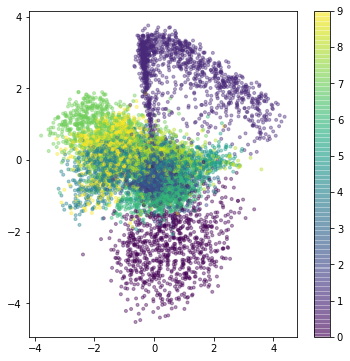

In [38]:
encoder = Model(x, z_mu)

# display a 2D plot of the digit classes in the latent space
z_test = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')
plt.colorbar()
plt.show()

The distribution of the encoded means shows how they are clustered by class too, as in the autoencoder case. However, in this case, the distribution also follows a kind of circular distribution around the centre due to the Kullback Leibler divergence term in the loss. We made the $\mu_x$ output by the encoder to be close to zero, and $\sigma_x$ to be close to 1. 

Now let's start with the generation of data, which is the main reason we trained this model. 

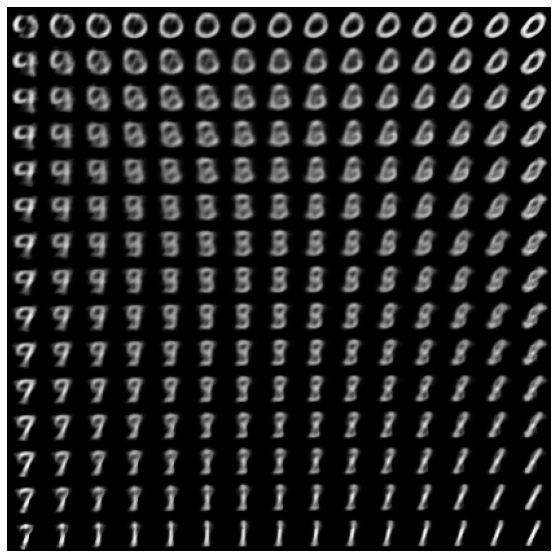

In [39]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))

x_pred_grid = decoder.predict(z_grid.reshape(n*n, latent_dim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

You can see in the image how there is a smooth transition between the different generated numbers.

Now let's generate a nice animation for the latent variable, where we show the point we used in $z$ to generate the data and the corresponding image generated.

In [47]:
## We create a 2d array
# Number of points to use, increase it for smoother animation
# Using more points makes the function slower
n_points = 50
# theta from 0 to 2pi
theta = np.linspace(0, 2*np.pi, n_points)
# radius of the circle (vary it depending on your reprentation space plot)
r = 1
# compute x and y (you can add an offset depending on your latent space)
offset_x = 0
offset_y = 0
x = r*np.cos(theta) + offset_x
y = r*np.sin(theta) + offset_y
latent = np.stack([x, y], -1)

input_noise = np.random.normal(0,1,size=[10000,10])
input_noise = input_noise.reshape(10000, 28, 28, 1)
latent_im = decoder.predict(latent)
print(input_noise-latent_im[0].reshape(28, 28))

ValueError: ignored

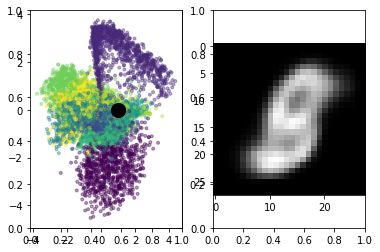

In [43]:
## We create a 2d array
# Number of points to use, increase it for smoother animation
# Using more points makes the function slower
n_points = 50
# theta from 0 to 2pi
theta = np.linspace(0, 2*np.pi, n_points)
# radius of the circle (vary it depending on your reprentation space plot)
r = 1
# compute x and y (you can add an offset depending on your latent space)
offset_x = 0
offset_y = 0
x = r*np.cos(theta) + offset_x
y = r*np.sin(theta) + offset_y
latent = np.stack([x, y], -1)

## We now plot as before the 2d scatter with the images from the test set 
## and the corresponding label
z_test = encoder.predict(x_test, batch_size=batch_size)
fig, ax = plt.subplots(1,2)
ax = fig.add_subplot(121)
ax.scatter(z_test[:, 0], z_test[:, 1], c=y_test,
            alpha=.4, s=3**2, cmap='viridis')

## This is needed to print the circle point (black point in the animation)
scat = ax.scatter(latent[0,0], latent[0,1], s=200, c='k')

## Create second plot with the generated image
fig.add_subplot(122)
latent_im = decoder.predict(latent)
im = plt.imshow(latent_im[0].reshape(28, 28), animated=True, cmap='gray')
def updatefig(i):
    global latent_im
    global latent, scat
    scat.set_offsets(latent[i])
    im.set_array(latent_im[i].reshape(28, 28))
    return im,
from matplotlib import animation
anim = animation.FuncAnimation(fig, updatefig, interval=200, save_count=latent.shape[0])
from IPython.display import HTML
HTML(anim.to_html5_video())

# Generative Adversarial Networks



![](https://skymind.ai/images/wiki/GANs.png)
[Image taken from here](https://skymind.ai/wiki/generative-adversarial-network-gan)

Generative Adversarial Networks have been shown to improve the generation of data compared to approaches such as VAE.

As you learnt in the lecture, we have two networks playing what is called a min max game between them. The **Generator, $G$, tries to generate data that looks similar to real data**, whereas the **discriminator $D$ tries to distinguish between real and fake data.**

Code adapted from [here](https://oshearesearch.com/index.php/2016/07/01/mnist-generative-adversarial-model-in-keras/).


We first define $G$ here, and in this case we will use a convolutional network. Notice that we use what is called LeakyReLU for the activation functions, which have been shown to work well when using GANs. $G$ will take a vector of noise (in this case of dimensionality 10) sampled from $\mathcal{N}(0, 1)$ and output a generated image. We use `tanh` as the last activation because the data will be normalized to be between $[-1, 1]$.

In [65]:
# Build Generative model
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)
randomDim = 10
# Generator
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(1, kernel_size=(5, 5), padding='same', activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 6272)              68992     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 64)      

Here, we define the discriminator $D$. The **discriminator is trained with the `categorical_crossentropy` loss, but you could also use a binary loss, as its job is to discriminate between real and fake data.**

In [66]:
# Build Discriminative model ...
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', input_shape=(28, 28, 1), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

We defined the combined network, which combines the generator and discriminator in a network. The discriminator, however, will not be updated when using this combined network. We will explain later why, but basically we will use the `discriminator` object (not the combined network) whenever we need to update the discriminator.

In [67]:
# Combined network

discriminator.trainable = False
ganInput = Input(shape=(randomDim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)
gan.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 10)                0         
_________________________________________________________________
sequential_6 (Sequential)    (None, 28, 28, 1)         275457    
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 212865    
Total params: 488,322
Trainable params: 275,457
Non-trainable params: 212,865
_________________________________________________________________


Now, let's define some helper functions that will be used to plot the loss and some generated images during training.

In [0]:
def plot_loss(losses):
    plt.figure()
    plt.plot(losses["d"], label='discriminitive loss')
    plt.plot(losses["g"], label='generative loss')
    plt.legend()
    plt.savefig('./loss.png')
    plt.close()
def plot_gen(mnist=1, n_ex=16, dim=(4,4), figsize=(10,10)):
    noise = np.random.normal(0,1,size=[n_ex,randomDim])
    generated_images = generator.predict(noise)
    
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],i+1)
        if mnist:
          img = generated_images[i,:,:,0]
          plt.imshow(img, cmap='gray')
        else:
          img = generated_images[i,:,:,:]
          plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('./images.png')
    plt.close()

We will not use the regular fit method to train the model as in the usual approach. The reason for this is that the min max game that the GANs do, in practice is implemented in each of the batches by using two different training steps.
* **First step - Training the discriminator:** In this step only the discriminator is trained.  The generator will output some fake images using noise as input. Then, we will give the discriminator these generated images and some images sampled from the real dataset and train it to distinguish between the two of them. 

* **Second step - Updating the generator**: We use the generator to output fake images again, and the discriminator will try to guess if these newly generated images are real or fake. However, the aim in this second step is not to update the discriminator, only the generator. **This is why in the combined network we made the discriminator not to be trainable**. The discriminator is used to pass information (in the form of gradients in this case) to update the generator. Hence, the generator will try to change its weights to make the discriminator think the data comes from the real distribution.

In [0]:
def train_epoch(gan, generator, discriminator, plt_frq=25, BATCH_SIZE=32, mnist=1):  
  vector_ind = np.random.permutation(x_train.shape[0])
  nb_epoch = int(x_train.shape[0]/BATCH_SIZE)
  pbar = tqdm_notebook(range(nb_epoch))
  for e in range(nb_epoch):  
    ind = vector_ind[e*BATCH_SIZE:(e+1)*BATCH_SIZE]
    # Make generative images
    image_batch = x_train[ind,:,:,:]    
    noise_gen = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    generated_images = generator.predict(noise_gen)
    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*BATCH_SIZE])
    y[0:BATCH_SIZE] = 1
    y[BATCH_SIZE:] = 0

    #make_trainable(discriminator,True)
    d_loss  = discriminator.train_on_batch(X,y)
    losses["d"].append(d_loss)
    # train Generator-Discriminator stack on input noise to non-generated output class
    noise_tr = np.random.normal(0,1,size=[BATCH_SIZE,randomDim])
    y2 = np.zeros([BATCH_SIZE])
    y2[:] = 1

    #make_trainable(discriminator,False)
    g_loss = gan.train_on_batch(noise_tr, y2 )
    losses["g"].append(g_loss)

    # Updates plots. This is a little bit of a mess due to how the notebook
    # handles the outputs
    if e % plt_frq==plt_frq-1:
      plot_loss(losses)
      plot_gen(mnist)
      fig, ax = plt.subplots(2,1, figsize=(20,10) )
      img=mpimg.imread('loss.png')
      ax[0].imshow(img)
      ax[0].axis('off')
      img=mpimg.imread('images.png')
      ax[1].imshow(img)
      ax[1].axis('off')
      plt.tight_layout()
      display.clear_output(wait=True)
      pbar.update(plt_frq)
      display.display(pbar)
      display.display(fig)
      plt.close()


Let's start the training process. We will use MNIST again. A standard practice for GANs is to normalize images to the range $[-1, 1]$, which we do. We train it for 2 epochs.

In [70]:
# set up loss storage vector
losses = {"d":[], "g":[]}
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 127.5 - 1
x_test = x_test.reshape(-1, 28, 28, 1) / 127.5 - 1 
n_epoch = 2
for i in range(n_epoch):
  train_epoch(gan, generator, discriminator, plt_frq=200,BATCH_SIZE=32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


KeyboardInterrupt: ignored

The plots show how the training loss for both the generator and the discriminator does not change much. Usually we have a model which we optimize to reduce some metric/loss we pass it. However, in this case we have two models which are 'competing' against each other, so their losses are approximately stable. Now let's plot some results, as in the VAE case, we plot the results when sampling from 2 of the dimensions of the input noise $z$. However, as in this case we used more than 2 dimensions for $z$, the results vary due to choosing at random the 2 dimensions where to sample from.

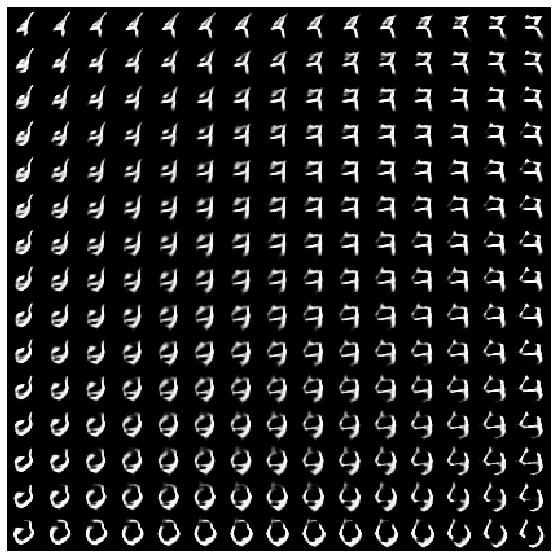

In [0]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28

# linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian to produce values
# of the latent variables z, since the prior of the latent space
# is Gaussian

z1 = norm.ppf(np.linspace(0.01, 0.99, n))
z2 = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid = np.dstack(np.meshgrid(z1, z2))
z_fill = np.random.normal(0,1,size=[randomDim-2])
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.expand_dims(z_fill, 0)
z_fill = np.repeat(z_fill, n, 0)
z_fill = np.repeat(z_fill, n, 1)

z_grid = np.concatenate([z_grid, z_fill], -1)
np.random.shuffle(z_grid[:,:,-1])
x_pred_grid = generator.predict(z_grid.reshape(n*n, randomDim)) \
                     .reshape(n, n, digit_size, digit_size)

plt.figure(figsize=(10, 10))
plt.imshow(np.block(list(map(list, x_pred_grid))), cmap='gray')
plt.axis('off')
plt.show()

## Training instability
GANs are quite difficult to train as there are several factors that can hurt their performance. Some of the most frequent issues are: 

* [Mode collapsing](https://www.youtube.com/watch?v=ktxhiKhWoEE): **The generator is not capable of creating diverse images, it only generates a limited set of images.**
* Discriminator loss decreases quickly: in some cases the **discriminator may be too powerful, so it quickly learns at the beginning which images are fake and which real, leading to small gradients passed to the generator**.
* Hyper parameter sensitivity
* Non-convergence

There are some tricks that have been shown to improve convergence, some of them are shared in this [repo](https://github.com/soumith/ganhacks).



# Inception Score


The evaluation of a generative model quantitatively is a problem that is being research. The metric should evaluate the coverage, i.e. **how diverse the generated data is**, and sample quality, which is related to the **visual quality of the sample**. A widely used metric is the Inception Score, which is defined as:
$$
\text{IS}(G)= \exp(\mathbb{E}_{x\sim p_a}\ D_{KL}(p(y|x)||p(y)))
$$
Let's explain the term a little bit. We aim to have a high IS, which means that we want a high $D_{KL}$ between $p(y|x)$ and $p(y)$. Ideally, what we want is $p(y|x)$ to be "peaky" and $p(y)$ to be uniform. $p(y|x)$ is the predicted probability vector $y$ given a generated sample $x$ by a model, in this case an Inception model (hence, the name of the score). If **the sample $x$ is of high quality, the model should classify it with confidence in one of the available classes,** hence the "peaky" $p(y|x)$. The term $p(y)$ is related to the diversity of the data, and is the marginal probability computed as $\int_z p(y|x=G(z))dz$, hence we average the predicted probabilites of the Inception model for the given samples. If the data is diverse, we will see approximately obtain a flat $p(y)$.


Code to compute the inception score adapted from [here](http://bluewidz.blogspot.com/2017/12/inception-score.html).

In [0]:
!wget https://imperialcollegelondon.box.com/shared/static/5cc14wf0s4qwj65lec5852jlmxfy32m9.h5 -O inception_score_mnist.h5
inception_score_model = keras.models.load_model('./inception_score_mnist.h5')

In [0]:
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from keras.datasets import mnist
from PIL import Image as pil_image


def inception_score(x, resizer=None, batch_size=32, denorm_im=1):
    r = None
    n_batch = (x.shape[0]+batch_size-1) // batch_size
    for j in range(n_batch):
        x_batch = x[j*batch_size:(j+1)*batch_size, :, :, :]
        if denorm_im:
          x_batch = (x_batch + 1)/2
        r_batch = inception_score_model.predict(x_batch) # r has the probabilities for all classes
        r = r_batch if r is None else np.concatenate([r, r_batch], axis=0)
    p_y = np.mean(r, axis=0) # p(y)
    e = r*np.log(r/p_y) # p(y|x)log(P(y|x)/P(y))
    e = np.sum(e, axis=1) # KL(x) = Σ_y p(y|x)log(P(y|x)/P(y))
    e = np.mean(e, axis=0)
    return np.exp(e) # Inception score


def image_inception_score(generator, n_ex=10000, dim_random=10, input_noise=None, denorm_im=1):
    if input_noise is None:
      input_noise = np.random.normal(0,1,size=[n_ex,dim_random])
    x_pred = generator.predict(input_noise)
    if len(x_pred.shape)==2:
      x_pred = x_pred.reshape(n_ex, 28, 28, 1)
    return inception_score(x_pred, denorm_im=denorm_im)


Now let's check the Inception Score for the GAN model we have trained before.

In [64]:
image_inception_score(decoder, dim_random=latent_dim, denorm_im=0)

5.7213507

Due to the way we defined the generator for the GAN, images are generated in the range $[-1, 1]$ as we use a `tanh` activation function. That is why we use the `denorm_im` variable to map them to the range $[0, 1]$.

The decoder of the VAE can also be evaluated using the same `image_inception_score` function. A VAE uses a prior $\mathcal{N}(0,1)$ as an extra constraint in the loss, hence if we sample from $\mathcal{N}(0,1)$ as done in `image_inception_score`, the decoder should be able to generate new samples. When using the function for the VAE, use `image_inception_score(..., denorm_im=0)` as the decoder in the VAE already uses the range $[0,1]$.

# Conditional Generative Adversarial Networks (cGANs)

A Conditional GAN (cGAN) is a variant of classical Generative Adversarial Networks, where the input and output are conditioned on some extra information instead of random noise. They were introduced in 2014, [link to the paper](https://arxiv.org/abs/1411.1784), and set a new state of the art in many image tasks.

Let's visualize a simple example of image translation,  drawing/real object transformation. To do so, imagine that we have two different paired domains, **images of the real objects** (domain A) and **drawing of objects** (domain B), and **we want to go from one to the other**. In classical GANs, we used these two domains for training the architecture, but here we can also condition the input to one of the images in the domain B, and use the relationship between the domains to guide the network to the desired result:

<a href="https://imgbb.com/"><img src="https://i.ibb.co/rF2w5Tt/Screenshot-from-2019-02-25-15-47-18.png" alt="Screenshot-from-2019-02-25-15-47-18" border="0"></a>

As in regular GANs, the discriminator learns to classify between fake (synthesized by the generator) and real {drawing, photo} tuples, meanwhile, the generator will try to fool the discriminator with better and better synthesized images. In contrast to GANS, **as we feed the drawing directly to the generator, the information that the network can use to seek convergence is much wider than in classical GANs. **

## Image-to-image Translation with cGANs


[Image-to-image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004) is a paper presented in the Computer Vision and Pattern Recognition (CVPR) conference in 2017. In their paper, authors introduced Pix2pix, a conditional GAN, to transform images from one domain to another. Authors in the paper investigated conditional adversarial networks as a general-purpose solution to image-to-image translation problems, see some examples from the paper of different image domain transformations:





> 




![texto alternativo](https://i.ibb.co/Mf08787/examples.jpg)


In this tutorial, we will explain and implement Pix2pix model **for coloring images step by step.**

## Coloring Black and White Images

The tutorial aims to build the Pix2pix code for coloring images. We will use CIFAR10 dataset to perform the experiment, however, you could try to use any other dataset. For instance, check [this repo](https://github.com/kvfrans/deepcolor) which shows how to color manga-style images. 

The idea is quite intuitive, first of all, we will transform images into black and white (BW) and train a generator that will transform them back to RGB images. As in classical GANs, we use the discriminator to differentiate between *Fake* and *Real* images. 

Thus, we have domain A (color) and domain B (B&W).



## Dataset Generator

When training a cGAN, or any regular GAN architecture, we need to train independently the generator and discriminator networks. As seen, the training is a min-max game between the two nets.

Firstly, we aim to train the generator to be able to fool the discriminator, while in the next iteration, we will train the discriminator to be able to distinguish between the generated (fake) images and the real ones. 

We are going to switch the training between networks in every step. Instead of training per a whole epoch as has been seen in the previous tutorials, we will generate batches and train first the discriminator and then switch to train the generator. 

To accomplish that, we need to use the module provided by Keras *model.train_on_batch()* and code our training loop. In this case, we can not rely on Keras *model.fit()* module to handle the dataset as done previously, but instead we need to create a dataset generator to feed with batches our training loop. 

We need to define our class *DataLoader()*:

In [0]:
import keras
from keras.datasets import cifar10, cifar100
from keras.layers import Lambda, Input
from keras.models import Model
import tensorflow as ktf
import numpy as np
import matplotlib.pyplot as plt
import datetime

class DataLoader():
  def __init__(self, dataset_name, img_res=(32, 32)):
    self.dataset_name = dataset_name
    self.img_res = img_res
    self.load_dataset()
  
  def _start_epoch(self):  
  
    random_idx = np.random.permutation(len(self.im_A_train))
    self.im_A_train_epoch = self.im_A_train[random_idx]
    
  def load_dataset(self):
    
    if self.dataset_name == 'CIFAR10':
      (im_A_train, y_train), (im_A_test, y_test) = cifar10.load_data()
    elif self.dataset_name == 'CIFAR100':
      (im_A_train, y_train), (im_A_test, y_test) = cifar100.load_data()
    else:
      raise Exception('Please, select a valid dataset')
      
    self.im_A_train = im_A_train.astype('float32')
    self.im_A_test = im_A_test.astype('float32')
    self.im_A_train /= 255.
    self.im_A_test /= 255.
    
  def get_dataset_shape(self, is_training=True):
    
    if is_training:
      return self.im_A_train.shape
    else:
      return self.im_A_test.shape
    
  def get_num_batches(self, batch_size):
    return int(self.im_A_train.shape[0] / batch_size)
  
  def set_image_transformations(self, convert_to_bw):
    
    self.convert_to_bw = convert_to_bw
  
  def load_batch(self, batch_size=1, is_training=True):
        
    if is_training:
      
      self._start_epoch()   
      num_batches = int((self.im_A_train).shape[0] / batch_size)
      
    else:
      num_batches = int((self.im_A_test).shape[0] / batch_size)
    
    for idx_batch in range(num_batches):
      
      init = idx_batch * batch_size
      end = (idx_batch + 1) * batch_size
      
      if is_training:
        batch = self.im_A_train_epoch[init:end]
      else:
        batch = self.im_A_test[init:end]
 
      batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
            
      # Convert to B&W
      batch_bw = self.convert_to_bw.predict(batch)
      
      yield [batch, batch_bw]

  def get_random_batch(self, batch_size=1, is_training=True):
    
    if is_training:
      random_idx = np.random.permutation(len(self.im_A_train))
      batch = self.im_A_train[random_idx[0:batch_size]]
    else:
      random_idx = np.random.permutation(len(self.im_A_test))
      batch = self.im_A_test[random_idx[0:batch_size]]

    batch = np.reshape(batch, (batch_size, self.img_res[0], self.img_res[1], 3))
        
    # Convert to B&W
    batch_bw = self.convert_to_bw.predict(batch)
      
    return [batch, batch_bw]

*DataLoader* class needs only the name of the dataset to load. Now, it can load CIFAR10 and CIFAR100. Let's see what some of *DataLoader*'s methods do:


*   *_start_epoch()* is a private method. It shuffles the dataset every time that *load_batch()* is called. 
*   *load_dataset()* loads the dataset into *DataLoader* object. 
*  *load_batch()* creates a python generator. In each iteration, it will return a batch from the shuffled dataset.

Let's now call the dataset class. 



In [0]:
# Load the data, shuffled and split between train and test sets
dataset_loader = DataLoader(dataset_name = 'CIFAR10')

training_shape = dataset_loader.get_dataset_shape()
test_shape = dataset_loader.get_dataset_shape(is_training=False)

print('Shape of Training Images: {}'.format(training_shape))
print('Shape of Test Images: {}'.format(test_shape))

170500096/170498071 [==============================] - 4s 0us/step
Shape of Training Images: (50000, 32, 32, 3)
Shape of Test Images: (10000, 32, 32, 3)


## Defining the Domains

As explained above, we will go from B&W to color images. In order to get the B&W images, we need to define *transform_bw*, a method that will transform images from domain A (color) to images in domain B (B&W). We have defined our task, the method, and the dataset. 

In [0]:
# Convert to greyscale color space
inp = Input(shape=(None, None, 3))
out = Lambda(lambda image: ktf.image.rgb_to_grayscale(image))(inp)

transform_bw = Model(inputs=inp, outputs=out)

# Set predefined transformation in DataLoader Class
dataset_loader.set_image_transformations(transform_bw)

We can visualize images from both domains before starting to code our cGAN. Rerun the following code to visualize different examples:

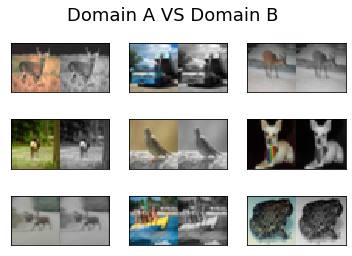

In [0]:
# Load random batch from dataset
random_batch = dataset_loader.get_random_batch(batch_size=9)

# Repeat last dimension for visualization
tmp = np.repeat(random_batch[1], 3, axis=3)

N=3
start_val = 0
fig, axes = plt.subplots(N,N)
plt.suptitle('Domain A VS Domain B', fontsize=18)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((random_batch[0][idx], tmp[idx]), 1)
    axes[row,col].imshow(np.clip(im, 0, 1))
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Generator & Discriminator Models
For many image translation problems, there is a great deal of **low-level information (i.e. crude features) shared between the input and output, and it would be desirable to shuttle this information directly across the net**. For example, in the case of image colorization, the input and output share the location of prominent edges. To give the generator a means to circumvent the bottleneck for information like this, we use architecture with **skip connections**, following the general shape of already presented UNet.

The generator presented in this tutorial is a simpler version of the one in the paper since we are using low-resolution images (32x32). You can find more complex/deeper versions of UNet in previous tutorials. 

In Pix2pix, the authors found that mixing the GAN objective with a more traditional loss, such as L1 loss, improved the final performance. The discriminator’s job remains unchanged, but the generator is tasked to not only fool the discriminator but also to be near the ground-truth output in an L1 sense.

We can define our cGAN generator model.

In [0]:
from keras.layers import Dropout, merge, concatenate, UpSampling2D, MaxPooling2D
from keras.layers import Conv2D, Dense, Reshape, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, Input, Dense, Reshape, Flatten
from keras.optimizers import Adam

def build_generator(im_shape):
  
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))
  
  ## Encoder part
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(img_B)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(rate=0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(rate=0.5)(conv5)

  ## Now the decoder starts
  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv10 = Conv2D(3, 3,  padding = 'same')(conv9)

  model = Model(inputs = img_B, outputs = conv10, name='generator')
  
  return model

Next, we follow the discriminator model definition from the paper:

In [0]:
def build_discriminator(im_shape):
  
  img_A = Input(shape=(im_shape[0], im_shape[1], 3))
  img_B = Input(shape=(im_shape[0], im_shape[1], 1))

  combined_imgs = concatenate([img_A, img_B], axis=-1)
    
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(combined_imgs)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Conv2D(64, kernel_size=(5, 5), padding='same', strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)

  disc_layer = Conv2D(128, kernel_size=(5, 5), strides=(2, 2))(disc_layer)
  disc_layer = BatchNormalization(momentum=0.8)(disc_layer)
  disc_layer = LeakyReLU(alpha=0.2)(disc_layer)
  
  disc_layer = Flatten()(disc_layer)
  disc_layer = Dense(1024)(disc_layer)

  prob = Dense(1, name="disc_dense")(disc_layer)

  discriminator = Model(inputs=[img_A, img_B], outputs=[prob], name='discriminator')
  
  return discriminator


## Training Loop

We arrive at the tricky part of the tutorial, where we need to define the training loop of the cGAN model. Do not focus much on this part of the code, this is only provided in case you want to further train the architectures.

First, we need to define the optimizers, inputs, outputs, and losses for each one of the networks. Let's go line by line:

In [0]:
# Define optimizers for each network.
# Note that if the discriminator is able to differentiate between samples, 
# the generator will be not able to learn. They must learn at the same time.
# Setting the learning rates or learning steps is always tricky.
optimizer_g = Adam(0.0002, 0.5)
optimizer_d = Adam(0.00002, 0.5)

# Input size
im_shape = (32, 32)

# Build and compile the discriminator
discriminator = build_discriminator(im_shape)
discriminator.compile(loss='mse', optimizer=optimizer_d, metrics=['accuracy'])

# Build the generator
generator = build_generator(im_shape)

# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# By conditioning on B generate a fake version of A.
# Remember, images in B are the B&W version of images in A
fake_A = generator(img_B)

# For the combined model we will only train the generator, thus, we freeze the
# discriminator model when optimizing G.
# We are backpropagating the discriminator's error
# into the generator in order to create fake images that are unrecognizable by D
discriminator.trainable = False

# Discriminators determines if a conditioned pair has been generated or is real
valid = discriminator([fake_A, img_B])

# Minimize discriminator error (only updating generator's weights) and 
# the L1 loss between real and fake images.
combined = Model(inputs=[img_A, img_B], outputs=[valid, fake_A])
combined.compile(loss=['mse', 'mae'], loss_weights=[1, 100], optimizer=optimizer_g)

We have created the models and compile them. Besides, before starting the training loop, we define two auxiliary functions that will allow us to print images during training to have an idea of how well the generator is coloring the images:

In [0]:
def showColoredIms(imB, fake_imA, real_imA):
  
  plt.subplot(131)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('Domain B', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(132)
  plt.imshow(np.clip(fake_imA[0], 0, 1)) 
  plt.title('Fake A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(133)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real A', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

def showColored_two_models_Ims(imB, fake_imA_MAE, fake_imA_cGAN, real_imA):
  
  plt.subplot(141)
  plt.imshow(np.clip(imB[0], 0, 1)[:,:,0], cmap='gray') 
  plt.title('BW', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(142)
  plt.imshow(np.clip(fake_imA_MAE[0], 0, 1)) 
  plt.title('MAE', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(143)
  plt.imshow(np.clip(fake_imA_cGAN[0], 0, 1))
  plt.title('cGAN', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.subplot(144)
  plt.imshow(np.clip(real_imA[0], 0, 1))
  plt.title('Real', fontsize=20)
  plt.gca().set_xticks([])
  plt.gca().set_yticks([])
  plt.show()

In the next section, we provide trained weights so you could resume or skip the training. These weights were obtained by training the net for 20 epochs. Note that if you want to further train the networks, GAN training is characterized for being really long. 

Let's see the training loop.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


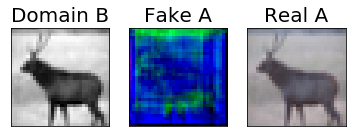

[Epoch 0/1] [Batch 0/390] [D loss: 1.792969, acc:  21%] [G loss: 53.144417] elapsed_time: 0:00:06.332089  remaining_time: 0:41:03.182621


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


[Epoch 0/1] [Batch 10/390] [D loss: 0.854814, acc:  37%] [G loss: 28.266876] elapsed_time: 0:00:07.801917  remaining_time: 0:04:28.811435
[Epoch 0/1] [Batch 20/390] [D loss: 0.716438, acc:  38%] [G loss: 20.363741] elapsed_time: 0:00:09.111668  remaining_time: 0:02:40.105041
[Epoch 0/1] [Batch 30/390] [D loss: 0.672440, acc:  37%] [G loss: 17.090345] elapsed_time: 0:00:10.455751  remaining_time: 0:02:01.084238
[Epoch 0/1] [Batch 40/390] [D loss: 0.650678, acc:  36%] [G loss: 15.099337] elapsed_time: 0:00:11.797808  remaining_time: 0:01:40.425099


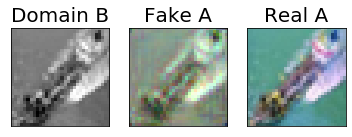

[Epoch 0/1] [Batch 50/390] [D loss: 0.633357, acc:  35%] [G loss: 13.761955] elapsed_time: 0:00:13.113523  remaining_time: 0:01:27.166392


In [0]:
num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)

# Adversarial loss ground truths. 
# They are used as labels for the discriminator loss.
valid = np.ones((batch_size,))
fake = np.zeros((batch_size,))
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []
  d_avg_loss = []
  d_avg_acc = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
      
    # ---------------------
    #  Train Discriminator
    # ---------------------
    
    # Condition on B and generate a translated (fake) version of A.
    # It will try to color images from B to be as similiar as possible 
    # to their correspoding pairs from A.
    fake_A = generator.predict(imgs_B)      

    # Train the discriminator (original images = real / generated = Fake)
    d_loss_real = discriminator.train_on_batch([imgs_A, imgs_B], valid)
    d_loss_fake = discriminator.train_on_batch([fake_A, imgs_B], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    d_avg_loss.append(d_loss[0])
    d_avg_acc.append(d_loss[1])
    
    # -----------------
    #  Train Generator
    # -----------------

    # Train the generators
    g_loss = combined.train_on_batch([imgs_A, imgs_B], [valid, imgs_A])
    g_avg_loss.append(g_loss[0])
    
    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      

    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f, acc: %3d%%] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(d_avg_loss), 100*np.mean(d_avg_acc), np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator.save('generator.h5') 
  discriminator.save('discriminator.h5')

If desired, you can download the weights for resuming future trainings. 

In [0]:
from google.colab  import files

# Download the weights in your PC
files.download('generator.h5') 
files.download('discriminator.h5')

## Coloring Test Images

We are ready to visualize how the network colors the test images. If you have not train your model, you can optionally load the provided weights so you can see how images look much better after training.

In [0]:
# Load weights from a previous session
# Upload weights to Colab by using the File tab

!wget -O weights.zip https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
!unzip -q ./weights.zip
!rm ./weights.zip

generator = keras.models.load_model('./weights/generator.h5')
discriminator = keras.models.load_model('./weights/discriminator.h5')

Let's see the results, you can rerun the following code for visualizing more examples:

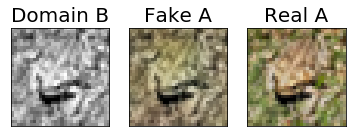

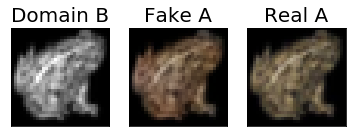

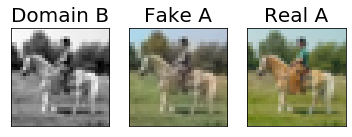

In [0]:
# Load random batch from dataset

for i in range(3):
  [im_A_real, im_B_test] = dataset_loader.get_random_batch(batch_size=1, is_training=False)

  im_A_fake = generator.predict(im_B_test)

  showColoredIms(im_B_test, im_A_fake, im_A_real)

We have shown a simplified version of the Pix2pix method. Training GANs is a hard task, and there are many elements that could be added to improve results. For instance, [this repo](https://github.com/soumith/ganhacks), like many others, shows common tricks to improve GAN performance.

# Coursework

### Task 1: MNIST generation using VAE and GAN

**Report**
* Train the given VAE model in the tutorial also using the same hyper parameters (batch size, optimizer, number of epochs, etc...). Compute the MAE on the reconstructed test images and Inception Score (IS). Increase the latent dimensionality (the dimensionality of the vector we use to decode the image) to 20 and compute the same metrics. Then add an extra layer (another `Dense(intermediate_dim, activation='relu')`) in both encoder and decoder and compute MAE and IS. Report the results in a table and discuss them. For the IS use in this case `image_inception_score(decoder, dim_random=latent_dim, denorm_im=0)` as explained in the tutorial.

* Train the GAN given in the tutorial for 10 epochs and report its IS. Then reduce the dimensionality of the initial random sample to 1. Train again. Compute IS for the new model. Report the results (you can add them to the same table used for VAE). How do the scores between the two GAN models compare? How is the diversity of the samples affected? Is the difference in IS between the two GAN models due to $p(y)$ term or due to $p(y|x)$ term? Discuss also the difference in the obtained IS for VAE and GAN. For the IS use in this case `image_inception_score(generator, dim_random=randomDim, denorm_im=1)` as explained in the tutorial.




### Task 2: Quantitative VS Qualitative Results

In this task, we will observe the difference between two trained models for coloring images. One is the model trained during the tutorial, which uses a cGAN approach to predict the RGB pixel-wise values of a B&W image. The other one is a simple UNet autoencoder trained with a Mean Absolute Error (MAE) loss, which is trained to predict directly the RBG image without any GAN based learning strategy. We refer to the first and second models as cGAN and MAE models, respectively. For this task, 20 epochs trained weights for the cGAN and MAE models are provided. If desired, as in cGAN model, the code to train the MAE model can be found below:

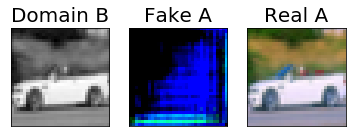

[Epoch 0/1] [Batch 0/390] [G loss: 0.730936] elapsed_time: 0:00:05.397487  remaining_time: 0:34:59.622443
[Epoch 0/1] [Batch 10/390] [G loss: 0.511831] elapsed_time: 0:00:06.623216  remaining_time: 0:03:48.200069
[Epoch 0/1] [Batch 20/390] [G loss: 0.321461] elapsed_time: 0:00:07.714516  remaining_time: 0:02:15.555102
[Epoch 0/1] [Batch 30/390] [G loss: 0.244758] elapsed_time: 0:00:08.817345  remaining_time: 0:01:42.110370
[Epoch 0/1] [Batch 40/390] [G loss: 0.202684] elapsed_time: 0:00:09.911995  remaining_time: 0:01:24.372844


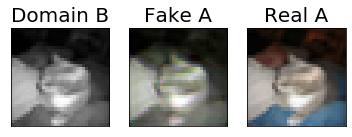

[Epoch 0/1] [Batch 50/390] [G loss: 0.175311] elapsed_time: 0:00:11.014363  remaining_time: 0:01:13.213152


In [0]:
# Input images and their conditioning images
img_A = Input(shape=(im_shape[0], im_shape[1], 3))
img_B = Input(shape=(im_shape[0], im_shape[1], 1))

# Build the generator
generator_mae = build_generator(im_shape)
fake_A = generator_mae(img_B)
generator_mae = Model(inputs=img_B, outputs=fake_A)
generator_mae.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])

num_epochs = 1
batch_size = 128
n_batches = dataset_loader.get_num_batches(batch_size)
     
for epoch in range(num_epochs):
  
  start_time = datetime.datetime.now()
  
  # Record average losses. Monitorize the loss function. 
  g_avg_loss = []

  # load_batch() returns a batch generator
  # Before starting the epoch, it shuffles the dataset
  for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(batch_size)):
    
    # -----------------
    #  Train Generator (MAE)
    # -----------------
    g_loss = generator_mae.train_on_batch(imgs_B, imgs_A)
    g_avg_loss.append(g_loss[0])

    fake_A = generator_mae.predict(imgs_B)  

    elapsed_time = datetime.datetime.now() - start_time
    
    # Aproximation of epoch remaining time
    remaining_time = (elapsed_time/(batch_i+1)) * (n_batches-batch_i-1)

    # Plot examples          
    if batch_i%50 == 0:
      showColoredIms(imgs_B, fake_A, imgs_A)      
    
    # Plot the progress
    if batch_i%10 == 0:          

      print ("[Epoch %d/%d] [Batch %d/%d] [G loss: %f] elapsed_time: %s  remaining_time: %s" % (epoch, num_epochs,
              batch_i, n_batches, np.mean(g_avg_loss), elapsed_time, remaining_time))            
        
  # Saves optimizer and weights
  generator_mae.save('generator_mae.h5') 

Instead of training the models we can load their weights by running:

In [0]:
!wget -O weights.zip https://imperialcollegelondon.box.com/shared/static/w2m93zcadbycpspaq4jifug9bo8l88ad.zip
!unzip -q ./weights.zip
!rm ./weights.zip

!wget -O weights_mae.zip https://imperialcollegelondon.box.com/shared/static/empxfp2v05xp7h8rwsccuiy35c3vddzd.zip
!unzip -q ./weights_mae.zip
!rm ./weights_mae.zip

generator_cGAN = keras.models.load_model('./weights/generator.h5')
generator_mae = keras.models.load_model('mae_generator.h5', compile=False)

generator_cGAN.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['mae'])
generator_mae.compile(optimizer='Adam', loss='mean_absolute_error', metrics=['mae'])

We have loaded both models and we are ready to compare them. In this task, you are asked to analyze the difference between the quantitative versus the qualitative results. To do so, we provided two pieces of code. The first one will compute the MAE metric for the full test dataset. This metric is widely used on image generation tasks, such as image upsampling, image reconstruction, image translation, and so on.



In [0]:
g_mae_avg_mae = []
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(128, is_training=False)):
    _, mae = generator_mae.evaluate(imgs_B, imgs_A, verbose=0)
    g_mae_avg_mae.append(mae)

print("MAE (Trained MAE): {:.4f}".format(np.mean(g_mae_avg_mae)))

g_cgan_avg_mae = []
for batch_i, [imgs_A, imgs_B] in enumerate(dataset_loader.load_batch(128, is_training=False)):
    _, mae = generator_cGAN.evaluate(imgs_B, imgs_A, verbose=0)
    g_cgan_avg_mae.append(mae)

print("MAE (Trained cGAN): {:.4f}".format(np.mean(g_cgan_avg_mae)))

MAE (Trained MAE): 0.0449
MAE (Trained cGAN): 0.0458


The next piece of code will show colored examples for both networks, so you can check them visually and discuss which model is better. First, we need to create an iterator object to go through the test dataset:

In [0]:
iterator = iter(dataset_loader.load_batch(1, is_training=False))

Run different examples so that you have a clear idea of how both methods differ.

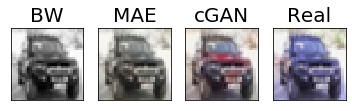

In [0]:
# Load test example
[imgs_A, imgs_B] = next(iterator)

# Generate predictions for both models
fake_A_cGAN = generator_cGAN.predict(imgs_B)
fake_A_MAE = generator_mae.predict(imgs_B)

# Plot all images
showColored_two_models_Ims(imgs_B, fake_A_MAE, fake_A_cGAN, imgs_A)

Both models obtain a similar MAE value, if we would only take into account the quantitative metric, as done in many scientific articles, we would say that the MAE model is better. However, in addition to the quantitative results, we can analyze visually the results produced by the two networks, and see how cGAN produces more realistic results than the MAE model, even though the colors do not align with the real ones. 

**Report**


*   Run the previous code to analyze several colored images for both models. Based on previous results and linked to GAN theory, discuss from the numerical and visual point of view if both models are similar, or if there is a better one. You can provide in the report visual examples together with their MAE values to support your arguments.